In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import compute_class_weight
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

print("TensorFlow Version:", tf.__version__)
print("Semua pustaka berhasil diimpor!")

In [ ]:
# --- Definisi Jalur & Parameter ---\n
EXCEL_PATH_TB = '../data/metadata_tuberkulosis.xlsx'
EXCEL_PATH_NORMAL = '../data/metadata_normal.xlsx'
IMAGE_DIR = '../data/all_image/'
NAMA_KOLOM_FILE = 'FILE NAME'

TARGET_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 32
EPOCHS = 30
NUM_CLASSES = 1

In [ ]:
# --- 1. Memuat dan Menggabungkan Data ---\n
try:
    df_tb = pd.read_excel(EXCEL_PATH_TB)
    df_tb.rename(columns={NAMA_KOLOM_FILE: 'File_Name_Clean'}, inplace=True)
    df_tb['Label'] = 'Tuberculosis'

    df_normal = pd.read_excel(EXCEL_PATH_NORMAL)
    df_normal.rename(columns={NAMA_KOLOM_FILE: 'File_Name_Clean'}, inplace=True)
    df_normal['Label'] = 'Normal'
except FileNotFoundError as e:
    print(f"ERROR: File Excel tidak ditemukan. Pastikan path sudah benar.")
    raise e

df = pd.concat([df_tb, df_normal], ignore_index=True)

# --- 2. Membuat Jalur File Lengkap ---\n
# Membersihkan nama file dan menambahkan ekstensi .png
df['File_Name_Clean'] = df['File_Name_Clean'].astype(str).str.strip() + '.png'
# Membuat path lengkap
df['path'] = df['File_Name_Clean'].apply(lambda x: os.path.join(IMAGE_DIR, x))

# Verifikasi
print(f"Total data: {len(df)}")
print("Distribusi kelas:")
print(df['Label'].value_counts())
print("\nContoh path:")
print(df['path'].head())

In [ ]:
# --- 3. Pembagian Data ---\n
# 70% training, 30% sisa
df_train, df_temp = train_test_split(
    df,
    test_size=0.30,
    stratify=df['Label'],
    random_state=42
)

# 15% validation, 15% testing
df_val, df_test = train_test_split(
    df_temp,
    test_size=0.50,
    stratify=df_temp['Label'],
    random_state=42
)

print(f"Jumlah data training: {len(df_train)}")
print(f"Jumlah data validasi: {len(df_val)}")
print(f"Jumlah data testing: {len(df_test)}")

In [ ]:
# --- 4. Menghitung Bobot Kelas ---\n
nama_kelas_unik = np.sort(df['Label'].unique())
bobot_kelas_array = compute_class_weight(
    class_weight='balanced',
    classes=nama_kelas_unik,
    y=df_train['Label']
)
class_indices = {name: i for i, name in enumerate(nama_kelas_unik)}
bobot_kelas_dictionary = {
    class_indices[name]: bobot_kelas_array[i]
    for i, name in enumerate(nama_kelas_unik)
}

print("Bobot kelas yang dihitung:")
print(bobot_kelas_dictionary)

In [ ]:
# --- 5. Membuat Data Generator ---\n
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    horizontal_flip=True,
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='path',
    y_col='Label',
    target_size=TARGET_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='path',
    y_col='Label',
    target_size=TARGET_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='path',
    y_col='Label',
    target_size=TARGET_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [ ]:
# --- 6. Membangun Model ---\n
base_model = ResNet50(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights='imagenet'
)

# Bekukan lapisan base model
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(NUM_CLASSES, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()

In [ ]:
# --- 7. Melatih Model ---\n
checkpoint = ModelCheckpoint(
    filepath='../web_app/tb_resnet_best.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

print(f"Memulai training dengan {train_generator.samples} sampel training dan {val_generator.samples} sampel validasi.")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    class_weight=bobot_kelas_dictionary,
    callbacks=[checkpoint]
)

print("Pelatihan selesai. Model terbaik disimpan di tb_resnet_best.h5")

In [1]:
# Tambahkan sel baru di notebook evaluasi/training Anda

from tensorflow.keras.models import load_model

# Muat model yang baru saja Anda simpan
model_to_inspect = load_model('../web_app/tb_resnet_best.h5')

# Ambil lapisan dasar (ResNet50) dari model sequential Anda
base_resnet = model_to_inspect.layers[0]

print("--- Daftar Lapisan ResNet50 (Lapisan Terakhir) ---")

# Cetak 10 nama lapisan terakhir untuk identifikasi
for layer in base_resnet.layers[-10:]:
    print(layer.name)

--- Daftar Lapisan ResNet50 (Lapisan Terakhir) ---
conv5_block3_1_conv
conv5_block3_1_bn
conv5_block3_1_relu
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out


In [16]:
# --- 8. Evaluasi Model pada Data Uji ---\n
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
import numpy as np

print("Memulai evaluasi pada data uji...")

# Muat model terbaik yang disimpan
model_final = load_model('../web_app/tb_resnet_best.h5')

# Prediksi pada data uji
Y_pred = model_final.predict(test_generator, steps=(test_generator.samples // BATCH_SIZE) + 1)
Y_pred_classes = (Y_pred > 0.5).astype(int)

# Dapatkan label yang sebenarnya
Y_true = test_generator.classes

# Dapatkan nama kelas dari generator
target_names = list(test_generator.class_indices.keys())

# Tampilkan Laporan Klasifikasi
print("\n--- Classification Report ---\n")
print(classification_report(Y_true, Y_pred_classes, target_names=target_names))

Memulai evaluasi pada data uji...


c:\ProgramData\anaconda3\envs\tb_skripsi\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step

--- Classification Report ---

              precision    recall  f1-score   support

      Normal       0.86      0.95      0.90       525
Tuberculosis       0.49      0.22      0.30       105

    accuracy                           0.83       630
   macro avg       0.67      0.59      0.60       630
weighted avg       0.80      0.83      0.80       630



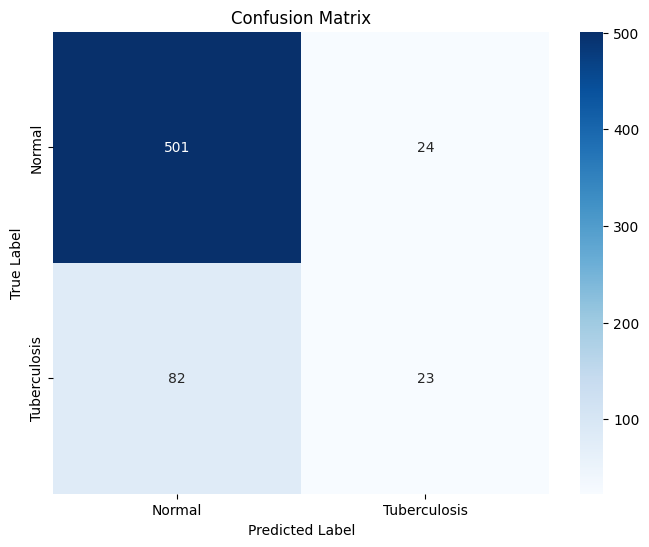

In [17]:
# --- 9. Tampilkan Confusion Matrix ---\n
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()